# Full Ruleset Demo — Optical MEMS PDK

Demonstrates all 19 process layers (10 structure, 6 mask, 3 dummy) with three
representative structures built from atomic shape generators.

| Structure | Layers demonstrated |
|---|---|
| **Photonic waveguides** (strip + rib) | SI_FULL, SI_PARTIAL, MASK_SI_FULL_ETCH, MASK_SI_PARTIAL_ETCH |
| **Anchor pad with metal contact** | SI_FULL, OXIDE_LTO, OXIDE_PSG, POLY_ANCHOR, POLY_TOP, METAL, MASK_ANCHOR_ETCH, MASK_PSG_ETCH, MASK_METAL_LIFTOFF, HARD_MASK, METAL_LIFTOFF_AUX |
| **Released MEMS actuator** | POLY_MEMS, MASK_POLYSI_ETCH, RELEASE |
| **Background chip area** | SI_SUBSTRATE, OXIDE_SOI |

In [1]:
import sys
sys.path.insert(0, "../../libraries")

import gdsfactory as gf
from mcw_custom_optical_mems_pdk import LAYER, DESIGN_RULES as DR, PDK

PDK.activate()

In [2]:
# ---------------------------------------------------------------------------
# Primitive shape generators
# ---------------------------------------------------------------------------

def centered_rect(w, h, layer):
    """Axis-aligned rectangle centered at origin on a single layer."""
    c = gf.Component()
    c.add_polygon(
        [(-w / 2, -h / 2), (w / 2, -h / 2), (w / 2, h / 2), (-w / 2, h / 2)],
        layer=layer,
    )
    return c


def plate_with_holes(w, h, hole_size, hole_pitch, layer):
    """Rectangular plate with a grid of square etch holes (boolean subtraction).

    Rules: M.02 hole_pitch <= 10, M.03 hole_size >= 2.0
    """
    plate = centered_rect(w, h, layer)
    holes = gf.Component()
    margin = hole_pitch / 2 + hole_size / 2
    nx = max(1, int((w - 2 * margin) / hole_pitch) + 1)
    ny = max(1, int((h - 2 * margin) / hole_pitch) + 1)
    for i in range(nx):
        for j in range(ny):
            x = -(nx - 1) * hole_pitch / 2 + i * hole_pitch
            y = -(ny - 1) * hole_pitch / 2 + j * hole_pitch
            ref = holes.add_ref(centered_rect(hole_size, hole_size, layer))
            ref.move((x, y))
    return gf.boolean(
        A=plate, B=holes, operation="not",
        layer1=layer, layer2=layer, layer=layer,
    )


def finger_array(n, length, width, gap, layer):
    """Row of comb fingers extending in +x from x=0, centered in y.

    Rules: W.06 width >= 0.5, S.06 gap >= 0.3, M.05 length/width <= 15
    """
    c = gf.Component()
    pitch = width + gap
    for i in range(n):
        y = -(n - 1) * pitch / 2 + i * pitch
        c.add_polygon(
            [(0, y - width / 2), (length, y - width / 2),
             (length, y + width / 2), (0, y + width / 2)],
            layer=layer,
        )
    return c

In [3]:
# ---------------------------------------------------------------------------
# Component builders — photonic waveguides
# ---------------------------------------------------------------------------

def strip_waveguide(length=25.0, width=0.5):
    """Strip waveguide: full-thickness SOI core + etch mask.

    Rules: W.01 width=0.5 >= 0.25
    """
    c = gf.Component()
    for lyr in [LAYER.SI_FULL, LAYER.MASK_SI_FULL_ETCH]:
        c.add_ref(centered_rect(length, width, lyr))
    return c


def rib_waveguide(length=25.0, core_w=0.5, slab_w=5.0, slab_len=20.0):
    """Rib waveguide: SI_FULL core + SI_PARTIAL slab + masks.

    Rules: W.01 core=0.5>=0.25, W.02 slab=5>=0.25,
           E.01 Si_full enc Si_partial = (25-20)/2 = 2.5 >= 0.3,
           X.01 slab extends past core  = (5-0.5)/2 = 2.25 >= 0.2
    """
    c = gf.Component()
    for lyr in [LAYER.SI_FULL, LAYER.MASK_SI_FULL_ETCH]:
        c.add_ref(centered_rect(length, core_w, lyr))
    for lyr in [LAYER.SI_PARTIAL, LAYER.MASK_SI_PARTIAL_ETCH]:
        c.add_ref(centered_rect(slab_len, slab_w, lyr))
    return c


# ---------------------------------------------------------------------------
# Component builders — anchor pad with metal contact
# ---------------------------------------------------------------------------

def anchor_pad(metal_s=5.0, anchor_s=10.0, poly_s=11.0, si_s=12.0):
    """Multi-layer anchor pad with metal contact.

    Dimensions (all centered, µm):
        SI_FULL / OXIDE_LTO   12 x 12
        POLY_TOP              11 x 11
        POLY_ANCHOR           10 x 10
        OXIDE_PSG             10 x 10   (= poly_s - 2*E.04)
        METAL                  5 x  5

    Rules satisfied:
        E.02  SI enc anchor   = (12-10)/2 = 1.0 >= 0.5
        E.03  poly enc anchor = (11-10)/2 = 0.5 >= 0.4
        E.04  poly enc PSG    = (11-10)/2 = 0.5 >= 0.5
        E.05  poly enc metal  = (11-5)/2  = 3.0 >= 0.5
        E.06  anchor enc metal= (10-5)/2  = 2.5 >= 2.0
        E.07  HM enc PSG_etch = 0.3
        W.05  metal width 5.0 >= 1.0
    """
    c = gf.Component()
    psg_s = poly_s - 2 * DR.enc_polysi_of_psg           # 10.0
    hm_s = psg_s + 2 * DR.enc_hard_mask_of_psg_etch     # 10.6

    # Structure layers (process order, bottom to top)
    c.add_ref(centered_rect(si_s, si_s, LAYER.SI_FULL))
    c.add_ref(centered_rect(si_s, si_s, LAYER.OXIDE_LTO))
    c.add_ref(centered_rect(psg_s, psg_s, LAYER.OXIDE_PSG))
    c.add_ref(centered_rect(anchor_s, anchor_s, LAYER.POLY_ANCHOR))
    c.add_ref(centered_rect(poly_s, poly_s, LAYER.POLY_TOP))
    c.add_ref(centered_rect(metal_s, metal_s, LAYER.METAL))

    # Mask layers
    c.add_ref(centered_rect(anchor_s, anchor_s, LAYER.MASK_ANCHOR_ETCH))
    c.add_ref(centered_rect(psg_s, psg_s, LAYER.MASK_PSG_ETCH))
    c.add_ref(centered_rect(metal_s, metal_s, LAYER.MASK_METAL_LIFTOFF))

    # Dummy / auxiliary layers
    c.add_ref(centered_rect(hm_s, hm_s, LAYER.HARD_MASK))
    c.add_ref(centered_rect(metal_s, metal_s, LAYER.METAL_LIFTOFF_AUX))

    return c


# ---------------------------------------------------------------------------
# Component builders — released MEMS actuator
# ---------------------------------------------------------------------------

def mems_geometry(layer, plate_w=24.0, plate_h=12.0,
                  hole_size=2.5, hole_pitch=8.0,
                  n_fingers=4, finger_l=7.0, finger_w=0.5, finger_gap=0.5,
                  beam_w=1.0, beam_l=15.0):
    """Shuttle plate + comb fingers + spring beam on one layer."""
    c = gf.Component()
    c.add_ref(plate_with_holes(plate_w, plate_h, hole_size, hole_pitch, layer))
    ref = c.add_ref(finger_array(n_fingers, finger_l, finger_w, finger_gap, layer))
    ref.move((plate_w / 2, 0))
    c.add_polygon(
        [(-plate_w / 2 - beam_l, -beam_w / 2), (-plate_w / 2, -beam_w / 2),
         (-plate_w / 2, beam_w / 2), (-plate_w / 2 - beam_l, beam_w / 2)],
        layer=layer,
    )
    return c


def mems_actuator():
    """Released MEMS comb-drive element with structural + mask + aux layers.

    Rules satisfied:
        W.06  finger_w  = 0.5 >= 0.5
        S.06  finger_gap= 0.5 >= 0.3
        M.01  beam_l    = 15  <= 65
        M.02  hole_pitch= 8   <= 10
        M.03  hole_size = 2.5 >= 2.0
        M.05  finger AR = 7/0.5 = 14 <= 15
        M.07  beam_w    = 1.0 >= 0.8
        W.08  release margin = 4.0 >= 3.0
    """
    c = gf.Component()
    plate_w, plate_h = 24.0, 12.0
    beam_l, finger_l = 15.0, 7.0

    # Structural poly-Si (moving part)
    c.add_ref(mems_geometry(LAYER.POLY_MEMS))
    # Corresponding etch mask (same geometry)
    c.add_ref(mems_geometry(LAYER.MASK_POLYSI_ETCH))

    # PSG sacrificial oxide region under the moving structure
    psg_margin = 1.0
    total_w = plate_w + beam_l + finger_l + 2 * psg_margin
    total_h = plate_h + 2 * psg_margin
    cx = (finger_l - beam_l) / 2
    ref_psg = c.add_ref(centered_rect(total_w, total_h, LAYER.OXIDE_PSG))
    ref_psg.move((cx, 0))

    # Release window (HF etchant access)
    release_margin = 4.0
    ref_rel = c.add_ref(centered_rect(
        total_w + 2 * release_margin,
        total_h + 2 * release_margin,
        LAYER.RELEASE,
    ))
    ref_rel.move((cx, 0))

    return c

## Photonic waveguides

Two side-by-side waveguides on the SOI layer. The **strip waveguide** (bottom) is a
simple 0.5 µm-wide ridge of full-thickness silicon. The **rib waveguide** (top) adds a
5 µm-wide partially-etched slab around the same 0.5 µm core — the slab is shorter than
the core so the full-thickness Si encloses it at both ends (rule E.01). Each waveguide
is drawn on its structure layer and the corresponding etch mask layer.

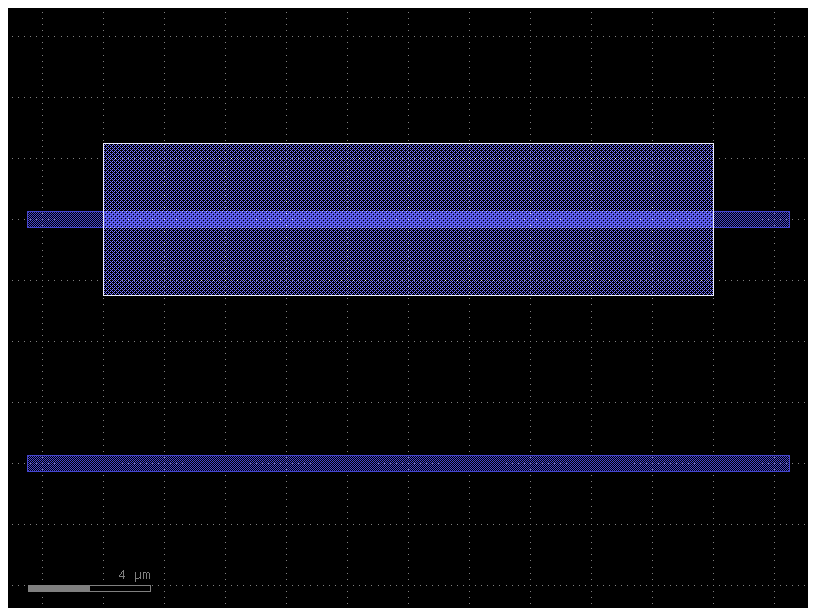

In [4]:
# ---------------------------------------------------------------------------
# Plot 1: Photonic waveguides (strip + rib)
# ---------------------------------------------------------------------------

wg_demo = gf.Component("waveguide_demo")
ref_strip = wg_demo.add_ref(strip_waveguide())
ref_strip.move((0, -4))
ref_rib = wg_demo.add_ref(rib_waveguide())
ref_rib.move((0, 4))
wg_demo.plot()

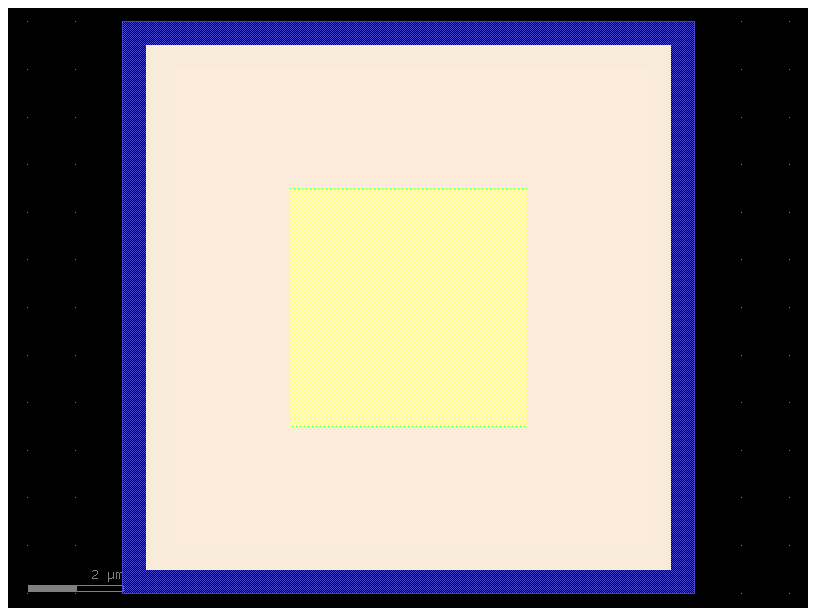

In [5]:
# ---------------------------------------------------------------------------
# Plot 2: Anchor pad with metal contact
# ---------------------------------------------------------------------------

anchor_pad().plot()

## Anchor pad with metal contact

A single anchored pad showing the full layer stack from substrate up to metal. Concentric
rectangles shrink inward following the enclosure rules: a 12 µm SOI foundation encloses
a 10 µm anchor poly, which is enclosed by 11 µm structural poly, with a 5 µm metal
contact pad at the center. The PSG sacrificial window, hard mask, and all three
corresponding mask layers (anchor etch, PSG etch, metal lift-off) are drawn at the
correct sizes.

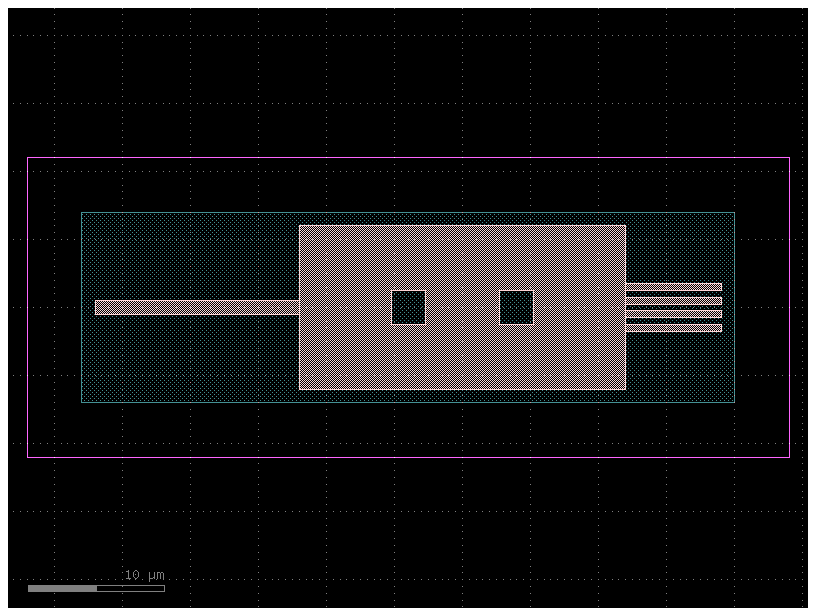

In [6]:
# ---------------------------------------------------------------------------
# Plot 3: Released MEMS actuator
# ---------------------------------------------------------------------------

mems_actuator().plot()

## Released MEMS actuator

A free-standing comb-drive element on the structural poly-Si layer. A 24 × 12 µm shuttle
plate has square etch holes punched out by boolean subtraction for HF release access.
Four comb fingers extend from the right edge and a 1 µm-wide spring beam extends from
the left. The entire structure is duplicated on the poly-Si etch mask layer, surrounded
by a PSG sacrificial oxide region, and enclosed in a release window that marks where HF
removes the sacrificial oxide to free the moving parts.

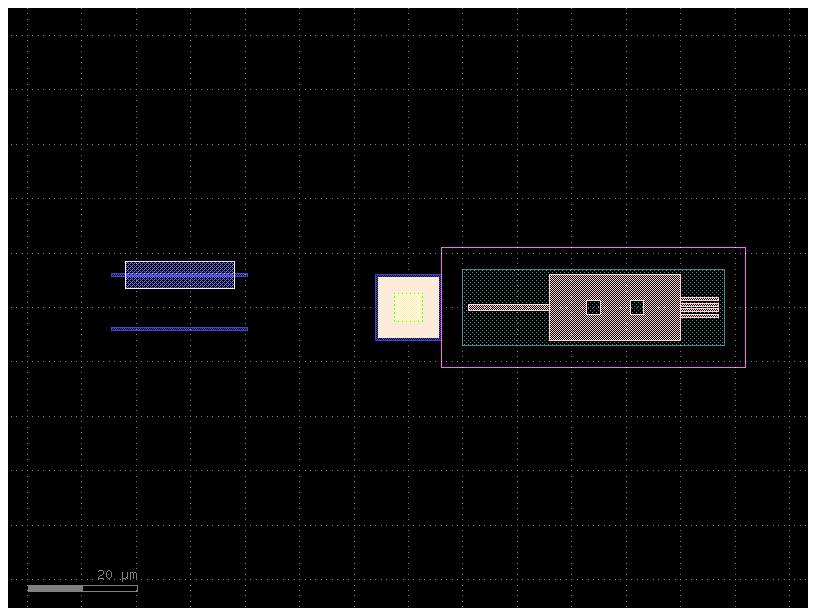

In [7]:
# ---------------------------------------------------------------------------
# Top-level assembly
# ---------------------------------------------------------------------------

def full_ruleset_demo():
    """Assemble all structures into a single component for visualization."""
    demo = gf.Component("full_ruleset_demo")

    # Background chip area (substrate + buried oxide)
    demo.add_ref(centered_rect(140.0, 45.0, LAYER.SI_SUBSTRATE))
    demo.add_ref(centered_rect(140.0, 45.0, LAYER.OXIDE_SOI))

    # Photonic waveguides (left region)
    ref_strip = demo.add_ref(strip_waveguide())
    ref_strip.move((-42, -4))

    ref_rib = demo.add_ref(rib_waveguide())
    ref_rib.move((-42, 6))

    # Anchor pad with metal contact (center)
    ref_pad = demo.add_ref(anchor_pad())
    # centered at origin

    # Released MEMS actuator (right region)
    ref_mems = demo.add_ref(mems_actuator())
    ref_mems.move((38, 0))

    return demo


demo = full_ruleset_demo()
demo.plot()